# **DSE-301 Assignment 1**

by Nirnay Roy
16128

## Installing Libraries

In [ ]:
! pip install chembl_webresource_client
! conda install -c rdkit rdkit -y
! conda install numpy -y
! conda install matplotlib -y
! conda install seaborn -y
! conda install scikit-learn -y
! conda install scipy

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda




In [51]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import NuSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ARDRegression
from sklearn.metrics import accuracy_score
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

## Import Data

In [52]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,14.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,14.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,5.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859


In [53]:
selected_target = targets.target_chembl_id[4]
selected_target

'CHEMBL3927'

In [54]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)

Saving the data in the data folder

In [55]:
df.to_csv(r'../data/bioactivity_data.csv', index=False)

## Pre-processing Data

Create a bioactivity class feature which classifies different molecules according to the standard value.

In [56]:
bioactivity_class = []
for i in df.standard_value:
  if float(i) >= 10000:
    bioactivity_class.append("inactive")
  elif float(i) <= 1000:
    bioactivity_class.append("active")
  else:
    bioactivity_class.append("intermediate")

In [57]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
df3 = df[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0
...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0


In [58]:
df3.insert(2, "Bioactivity Class", pd.Series(bioactivity_class), True) 
df3["Bioactivity Class"]

0      intermediate
1      intermediate
2          inactive
3          inactive
4      intermediate
           ...     
128        inactive
129        inactive
130        inactive
131        inactive
132        inactive
Name: Bioactivity Class, Length: 133, dtype: object

In [59]:
df_no_smiles = df3.drop(columns='canonical_smiles')

smiles = []

for i in df3.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,Bioactivity Class,standard_value,canonical_smiles
0,CHEMBL187579,intermediate,7200.0,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21
1,CHEMBL188487,intermediate,9400.0,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21
2,CHEMBL185698,inactive,13500.0,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21
3,CHEMBL426082,inactive,13110.0,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21
4,CHEMBL187717,intermediate,2000.0,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-]
...,...,...,...,...
128,CHEMBL2146517,inactive,10600.0,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...
129,CHEMBL187460,inactive,10100.0,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C
130,CHEMBL363535,inactive,11500.0,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12
131,CHEMBL227075,inactive,10700.0,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1


In [60]:
df_clean_smiles.to_csv(r'../data/bioactivity_preprocessed_data.csv', index=False)

## Finding Descriptors

In [61]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
128,338.359,3.40102,0.0,5.0
129,296.366,3.44330,0.0,3.0
130,276.291,4.09564,0.0,3.0
131,278.307,3.29102,0.0,3.0


In [62]:
df_combined = pd.concat([df3,df_lipinski], axis=1)

df_combined

,molecule_chembl_id,canonical_smiles,Bioactivity Class,standard_value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,7200.0,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,9400.0,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,13500.0,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,13110.0,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,2000.0,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,10600.0,338.359,3.40102,0.0,5.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,10100.0,296.366,3.44330,0.0,3.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,11500.0,276.291,4.09564,0.0,3.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,10700.0,278.307,3.29102,0.0,3.0


In [63]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [64]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        i = float(i)
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

df_norm = norm_value(df_combined)
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,Bioactivity Class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [83]:
df_2class = df_final[df_final['Bioactivity Class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,Bioactivity Class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


## Analysis of Descriptors

### pIC50

#### Box Plot

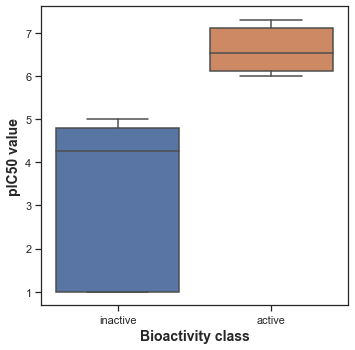

In [84]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Bioactivity Class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('../plots/plot_ic50.pdf')


#### Mann-Whitney U test

In [85]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'Bioactivity Class']
  df = df_2class[selection]
  active = df[df['Bioactivity Class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'Bioactivity Class']
  df = df_2class[selection]
  inactive = df[df['Bioactivity Class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = '../U_score test/mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.662636e-10,0.05,Different distribution (reject H0)


### Mol. Wt

#### Box Plot

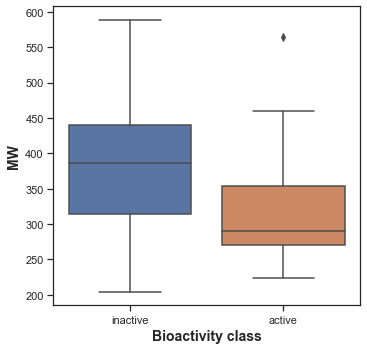

In [86]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Bioactivity Class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('../plots/plot_MW.pdf')

#### Mann-Whitney U test

In [87]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,411.5,0.001606,0.05,Different distribution (reject H0)


### logP

#### Box Plot

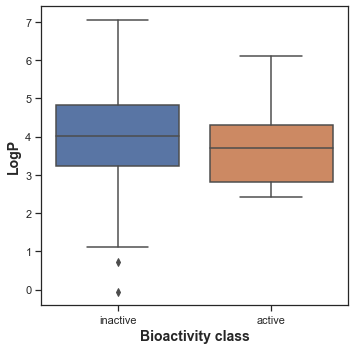

In [88]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Bioactivity Class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('../plots/plot_LogP.pdf')

#### Mann-Whitney U test

In [89]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,700.5,0.263499,0.05,Same distribution (fail to reject H0)


### No. of H-donors

#### Box Plot

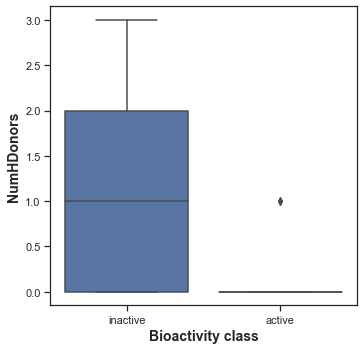

In [90]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Bioactivity Class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('../plots/plot_NumHDonors.pdf')

#### Mann-Whitney U test

In [91]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,299.5,0.000024,0.05,Different distribution (reject H0)


### No. of H-acceptors

#### Box Plot

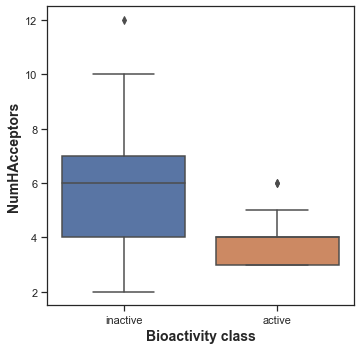

In [92]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Bioactivity Class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

#### Mann-Whitney U test

In [93]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,415.0,0.001557,0.05,Different distribution (reject H0)


## Prediction using ML models

### Train Test Split

In [94]:
features = ['MW', 'NumHDonors', 'NumHAcceptors']
X = df_final[features]
Y= df_final.pIC50
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### Gaussian Process Regressor


In [95]:
gpr = GaussianProcessRegressor()
gpr.fit(X_train, Y_train)
print('r2_score:', gpr.score(X_test, Y_test))

r2_score: -1.514581106553933


### NuSVR

In [96]:
nuregr = make_pipeline(StandardScaler(), NuSVR(C=1.0, nu=0.1))
nuregr.fit(X_train, Y_train)
print('r2_score:', nuregr.score(X_test, Y_test))

r2_score: 0.21406408788303322


### ARDRegression

In [97]:
linregr = ARDRegression(compute_score=True)
linregr.fit(X_train, Y_train)
print('r2_score:', linregr.score(X_test, Y_test))

r2_score: 0.11224257389673065
